<a href="https://colab.research.google.com/github/jungeun202/Transformer/blob/main/LUNA_testing_translationdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from [Transformer model with eng-spa translation dataset](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)

In [10]:
import torch
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
text_file = "/content/drive/MyDrive/spa.txt"

In [12]:
with open(text_file) as f:
    lines = f.read().split("\n")[:1600]

text_pairs = []
for line in lines:
    parts = line.split("\t")
    if len(parts) >= 2:  # Ensure there are at least two elements
        eng = parts[0]
        spa = parts[1]
        spa = "[start] " + spa + " [end]"
        text_pairs.append((eng, spa))

# Now text_pairs contains the processed text pairs
print(text_pairs)

[('Go.', '[start] Ve. [end]'), ('Go.', '[start] Vete. [end]'), ('Go.', '[start] Vaya. [end]'), ('Go.', '[start] Váyase. [end]'), ('Hi.', '[start] Hola. [end]'), ('Run!', '[start] ¡Corre! [end]'), ('Run!', '[start] ¡Corran! [end]'), ('Run!', '[start] ¡Huye! [end]'), ('Run!', '[start] ¡Corra! [end]'), ('Run!', '[start] ¡Corred! [end]'), ('Run.', '[start] Corra. [end]'), ('Run.', '[start] Corred. [end]'), ('Who?', '[start] ¿Quién? [end]'), ('Wow!', '[start] ¡Órale! [end]'), ('Duck!', '[start] ¡Inclínate! [end]'), ('Duck!', '[start] ¡Agáchate! [end]'), ('Duck!', '[start] ¡Agáchese! [end]'), ('Duck!', '[start] ¡Agáchense! [end]'), ('Duck!', '[start] ¡Agachaos! [end]'), ('Fire!', '[start] ¡Fuego! [end]'), ('Fire!', '[start] ¡Incendio! [end]'), ('Fire!', '[start] ¡Disparad! [end]'), ('Help!', '[start] ¡Ayuda! [end]'), ('Help!', '[start] ¡Socorro! ¡Auxilio! [end]'), ('Help!', '[start] ¡Auxilio! [end]'), ('Hide.', '[start] Escóndete. [end]'), ('Jump!', '[start] ¡Salta! [end]'), ('Jump.', '[star

In [13]:
import random

In [14]:
for _ in range(5):
    print(random.choice(text_pairs))

('Shoot!', '[start] Dispara. [end]')
('I ran.', '[start] Corrí. [end]')
('I was last.', '[start] Fui el último. [end]')
('Get to it.', '[start] Ponte a ello. [end]')
('Go away!', '[start] ¡Salga de aquí! [end]')


In [15]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

1600 total pairs
1120 training pairs
240 validation pairs
240 test pairs


In [16]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras.layers import TextVectorization

*   vocab_size : maximum number of unique tokens (words) to consider in the vocab
*   sequence_length : maximum length of the tokenized sequences.

In [17]:
strip_chars = string.punctuation + "¿" # the inverted question mark is for spanish
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
# remove all special characters

batch_size = 32 # the number of samples to process at once during training.

all_texts = [pair[0] for pair in text_pairs] + [pair[1] for pair in text_pairs]
unique_tokens = set()
for text in all_texts:
    unique_tokens.update(text.split())
vocab_size = len(unique_tokens)

print("vocab_size: " , vocab_size)

def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)  # Convert to lowercase
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")  # Remove punctuation


vocab_size:  2282




*   Batch size: hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
 * batch is small chunks to pass through the model
 * one iteration : **one forward pass and one backward pass** of one batch of data through the model
 * model's parameters are updated after each batch
*   Epochs: hyperparameter of gradient descent that controls the number of complete passes through the training dataset.
 * : one complete pass through the entire training dataset
 * use the full dataset in an epoch
 * The number of epochs is a measure of how many times the model has seen the entire dataset





In [18]:
def format_dataset(eng, spa): # takes eng and spa text pairs as input
# English texts are fed to the encoder and Spanish texts are fed to the decoder
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1], # exclude the last token ; used it as input to the decorder during training
        },
        spa[:, 1:], # Spanish texts excluding the first token; target output for the decorder
    )


def make_dataset(pairs): # takes a list of text pairs and prepares tensorflow dataset
    eng_texts, spa_texts = zip(*pairs) # split pairs
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts)) # creates a dataset
    dataset = dataset.batch(batch_size)  # batch
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from typing import Optional, Tuple
from torch import Tensor

class Embeddings(nn.Module):
    def __init__(self, vocab_num, d_model):
        super(Embeddings, self).__init__()
        self.emb = nn.Embedding(vocab_num, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int = 80, max_length: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_length, d_model, requires_grad=False)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, length: int) -> Tensor:
        return self.pe[:, :length]

class DotProductAttention(nn.Module):
    def __init__(self, dim: int, scale: bool = True) -> None:
        super(DotProductAttention, self).__init__()
        self.sqrt_dim = np.sqrt(dim) if scale else 1

    def forward(self, query: torch.FloatTensor, key: torch.FloatTensor, value: torch.FloatTensor, mask: Optional[torch.FloatTensor] = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        score = torch.matmul(query, key.transpose(2, 3)) / self.sqrt_dim
        if mask is not None:
            score.masked_fill_(mask, -1e4)
        attn = F.softmax(score, -1)
        context = torch.bmm(attn, value) if len(query.size()) == 3 else torch.matmul(attn, value)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, dim: int = 512, num_attention_heads: int = 8) -> None:
        super(MultiHeadAttention, self).__init__()
        assert dim % num_attention_heads == 0, "hidden_dim % num_attention_heads should be zero."
        self.d_head = int(dim / num_attention_heads)
        self.num_attention_heads = num_attention_heads
        self.query_proj = nn.Linear(dim, self.d_head * num_attention_heads)
        self.key_proj = nn.Linear(dim, self.d_head * num_attention_heads)
        self.value_proj = nn.Linear(dim, self.d_head * num_attention_heads)
        self.scaled_dot_attn = DotProductAttention(dim, scale=True)

    def forward(self, query: torch.FloatTensor, key: torch.FloatTensor, value: torch.FloatTensor, mask: Optional[torch.FloatTensor] = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        batch_size = value.size(0)
        query = self.query_proj(query).view(batch_size, -1, self.num_attention_heads, self.d_head).transpose(1, 2)
        key = self.key_proj(key).view(batch_size, -1, self.num_attention_heads, self.d_head).transpose(1, 2)
        value = self.value_proj(value).view(batch_size, -1, self.num_attention_heads, self.d_head).transpose(1, 2)
        if mask is not None:
            mask = mask.unsqueeze(1).repeat(1, self.num_attention_heads, 1, 1)
        context, attn = self.scaled_dot_attn(query, key, value, mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, self.num_attention_heads * self.d_head)
        return context, attn

class LinearUnifiedNestedAttention(nn.Module):
    def __init__(self, dim, num_attention_heads: int = 8) -> None:
        super(LinearUnifiedNestedAttention, self).__init__()
        self.pack_attention = MultiHeadAttention(dim, num_attention_heads)
        self.unpack_attention = MultiHeadAttention(dim, num_attention_heads)

    def forward(self, query: torch.FloatTensor, key: torch.FloatTensor, value: torch.FloatTensor, p: torch.FloatTensor, attention_padding_mask: torch.BoolTensor = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        packed_context, _ = self.pack_attention(p, key, value, attention_padding_mask)
        unpacked_context, _ = self.unpack_attention(query, packed_context, packed_context)
        return unpacked_context, packed_context

class PositionwiseFeedForwardNetwork(nn.Module):
    def __init__(self, d_model: int = 512, d_ff: int = 2048, dropout_p: float = 0.3) -> None:
        super(PositionwiseFeedForwardNetwork, self).__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.Dropout(dropout_p),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout_p),
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.feed_forward(inputs)

class LunaTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model: int = 512, num_attention_heads: int = 8, d_ff: int = 2048, dropout_p: float = 0.3) -> None:
        super(LunaTransformerEncoderLayer, self).__init__()
        self.luna_attention = LinearUnifiedNestedAttention(d_model, num_attention_heads)
        self.feed_forward = PositionwiseFeedForwardNetwork(d_model, d_ff, dropout_p)
        self.packed_context_layer_norm = nn.LayerNorm(d_model)
        self.unpacked_context_layer_norm = nn.LayerNorm(d_model)
        self.feed_forward_layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs: torch.FloatTensor, p: torch.FloatTensor, attention_padding_mask: torch.FloatTensor = None):
        unpacked_context, packed_context = self.luna_attention(query=inputs, key=inputs, value=inputs, p=p, attention_padding_mask=attention_padding_mask)
        packed_context = self.packed_context_layer_norm(packed_context + p)
        unpacked_context = self.unpacked_context_layer_norm(unpacked_context + inputs)
        outputs = self.feed_forward(unpacked_context)
        outputs = self.feed_forward_layer_norm(outputs + unpacked_context)
        return outputs, packed_context

def get_attn_pad_mask(inputs, input_lengths, expand_length):
    def get_transformer_non_pad_mask(inputs: Tensor, input_lengths: Tensor) -> Tensor:
        batch_size = inputs.size(0)
        non_pad_mask = inputs.new_ones(inputs.size()[:-1] if len(inputs.size()) == 3 else inputs.size())
        for i in range(batch_size):
            non_pad_mask[i, int(input_lengths[i]):] = 0
        return non_pad_mask

    non_pad_mask = get_transformer_non_pad_mask(inputs, input_lengths)
    pad_mask = non_pad_mask.lt(1)
    attn_pad_mask = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)
    return attn_pad_mask

def get_attn_subsequent_mask(seq):
    assert seq.dim() == 2
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1)
    return subsequent_mask.cuda() if seq.is_cuda else subsequent_mask

class LunaTransformerEncoder(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, num_layers: int = 6, num_attention_heads: int = 8, d_ff: int = 2048, dropout_p: float = 0.1, project_embedding_length: int = 5, max_length: int = 1024):
        super(LunaTransformerEncoder, self).__init__()
        self.d_model = d_model
        self.projected_embedding_length = project_embedding_length
        self.projected_embeddings = nn.Parameter(torch.Tensor(project_embedding_length, self.d_model))
        self.projected_positions = PositionalEncoding(self.d_model, project_embedding_length)
        nn.init.normal_(self.projected_embeddings, mean=0.0, std=self.d_model ** -0.5)
        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.dropout = nn.Dropout(p=dropout_p)
        self.input_positions = PositionalEncoding(d_model, max_length)
        self.input_norm = nn.LayerNorm(d_model)
        self.embed_scale = math.sqrt(self.d_model)
        self.layers = nn.ModuleList([
            LunaTransformerEncoderLayer(d_model=d_model, num_attention_heads=num_attention_heads, d_ff=d_ff, dropout_p=dropout_p) for _ in range(num_layers)
        ])
        self.projection_head = nn.Linear(d_model, vocab_size)

    def forward(self, inputs: torch.Tensor, input_lengths: torch.Tensor):
        batch_size, seq_length = inputs.size()
        attention_padding_mask = get_attn_pad_mask(inputs, input_lengths, self.projected_embedding_length)
        embedded = self.input_embedding(inputs) * self.embed_scale
        projected_embedded = self.projected_embeddings * self.embed_scale
        embedded += self.input_positions(embedded.size(1))
        projected_embedded += self.projected_positions(self.projected_embedding_length).squeeze(0)
        seq_length, dim = projected_embedded.size()
        projected_embedded = projected_embedded.unsqueeze(0).expand(batch_size, seq_length, dim)
        outputs = self.dropout(embedded)
        p = self.dropout(projected_embedded)
        for layer in self.layers:
            outputs, p = layer(outputs, p, attention_padding_mask)
        outputs = self.input_norm(outputs)
        outputs = self.projection_head(outputs)
        return outputs


In [20]:
import time
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt

Sequence Length: 1, Num Batches: 100
Epoch 1/20, Loss: 7.868427987098694
Epoch 2/20, Loss: 7.155028705596924
Epoch 3/20, Loss: 6.726037673950195
Epoch 4/20, Loss: 6.31765841960907
Epoch 5/20, Loss: 5.880746817588806
Epoch 6/20, Loss: 5.421957187652588
Epoch 7/20, Loss: 4.927631340026855
Epoch 8/20, Loss: 4.440888748168946
Epoch 9/20, Loss: 3.9700706386566162
Epoch 10/20, Loss: 3.4906099367141725
Epoch 11/20, Loss: 3.0511484813690184
Epoch 12/20, Loss: 2.6850404167175292
Epoch 13/20, Loss: 2.361212046146393
Epoch 14/20, Loss: 2.0844446873664855
Epoch 15/20, Loss: 1.8660520923137665
Epoch 16/20, Loss: 1.6940934360027313
Epoch 17/20, Loss: 1.5589687037467956
Epoch 18/20, Loss: 1.4788215065002441
Epoch 19/20, Loss: 1.4037078481912613
Epoch 20/20, Loss: 1.3399867695569991
Sequence Length: 1, Avg Loss: 3.7861266721487046, Time: 46.30760645866394
Sequence Length: 2, Num Batches: 100
Epoch 1/20, Loss: 7.846298446655274
Epoch 2/20, Loss: 7.3848592567443845
Epoch 3/20, Loss: 7.038276181221009
Ep

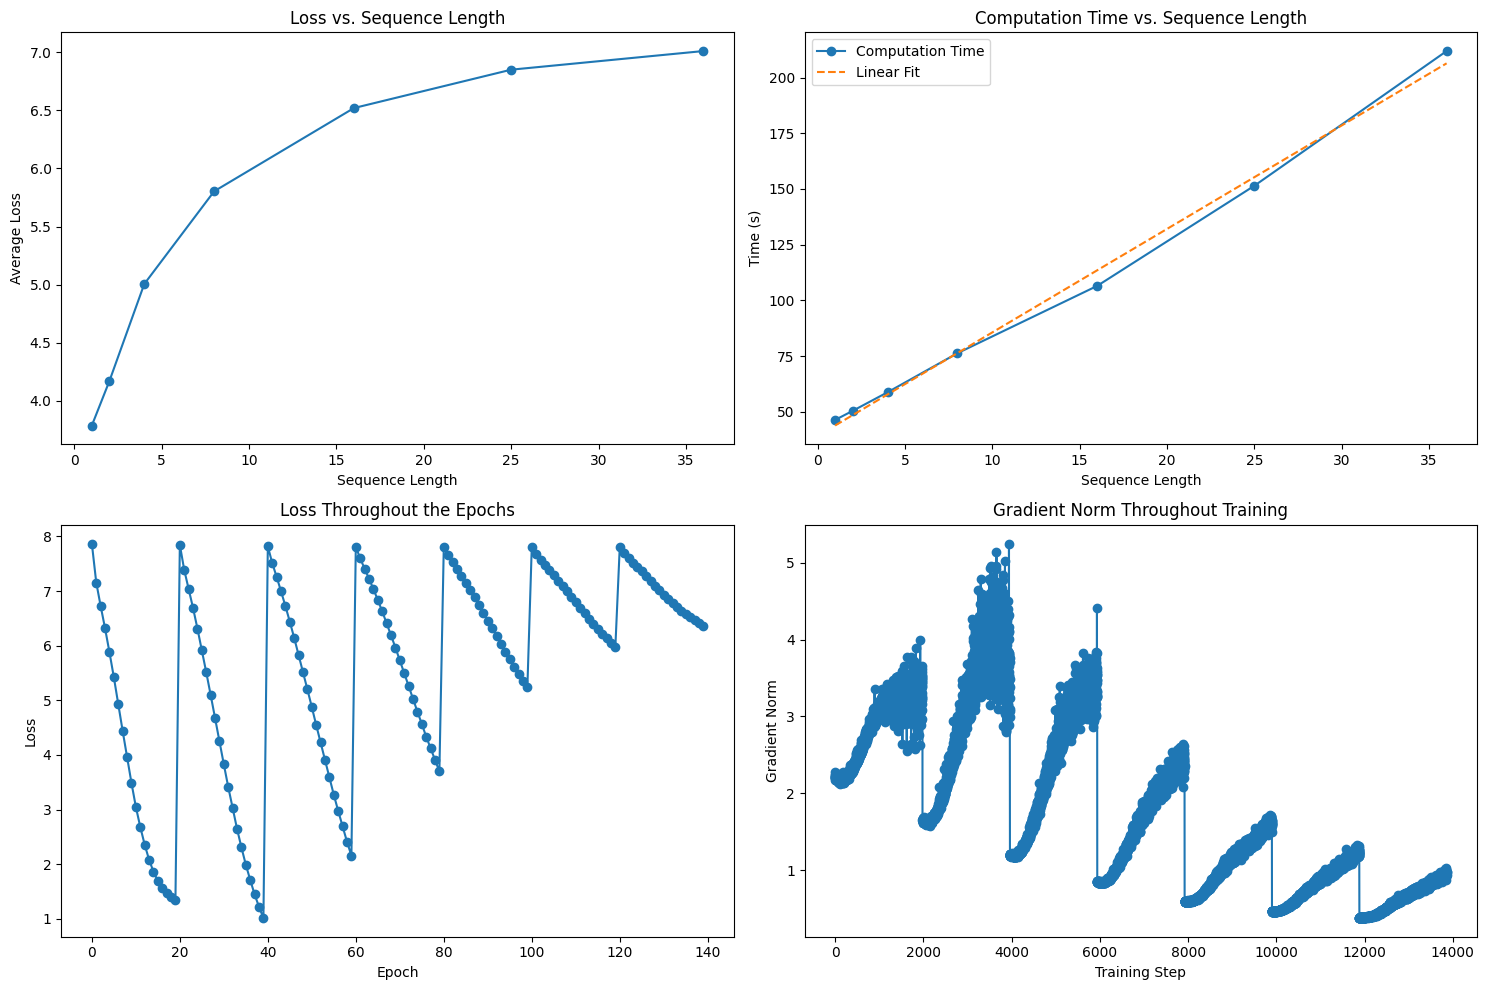

In [25]:
import torch.optim as optim
import torch
import time
import numpy as np
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define model parameters
dim = 128
depth = 1
num_epochs = 20
batch_size = 32
learning_rate = 5e-4
head_num = 8
sequence_lengths = [1, 2, 4, 8, 16, 25, 36]  # Sequence lengths to test

# Lists to store results
losses = []
times = []
epoch_losses = []
gradient_norms = []


# Training loop for different sequence lengths
for max_seq_len in sequence_lengths:

    # Vectorization
    eng_vectorization = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=max_seq_len,
    )
    spa_vectorization = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=max_seq_len + 1,
        standardize=custom_standardization,
    )

    train_eng_texts = [pair[0] for pair in train_pairs]
    train_spa_texts = [pair[1] for pair in train_pairs]
    eng_vectorization.adapt(train_eng_texts)
    spa_vectorization.adapt(train_spa_texts)


    train_ds = make_dataset(train_pairs)
    val_ds = make_dataset(val_pairs)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LunaTransformerEncoder(vocab_size, dim, depth, head_num, max_seq_len, dropout_p=0.1).to(device)

    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)  # Learning rate scheduler

    # Generate dummy data for the given sequence length
    ids = torch.randint(0, vocab_size, (batch_size, max_seq_len * 100)).to(device)  # Adjust size as needed
    num_batches = ids.size(1) // max_seq_len

    print(f"Sequence Length: {max_seq_len}, Num Batches: {num_batches}")

    # Train the model
    start_time = time.time()
    total_loss = 0

    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()  # Ensure the model is in training mode
        for i in range(0, ids.size(1) - max_seq_len, max_seq_len):
            # Get mini-batches
            inputs = ids[:, i:i+max_seq_len].to(device)
            targets = ids[:, (i+1):(i+1)+max_seq_len].to(device)

            # Forward pass
            input_lengths = (torch.ones(batch_size) * max_seq_len).to(torch.int32)  # A tensor of the same length for each sequence
            outputs = model(inputs, input_lengths)  # Process LunaTransformerEncoder's forward method
            output_flat = outputs.view(-1, vocab_size)  # Reshaped

            # Backward pass
            loss = criterion(output_flat, targets.reshape(-1))

            optimizer.zero_grad()
            loss.backward()

            # Calculate gradient norm
            total_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_norm = param.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            gradient_norms.append(total_norm)

            clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

            total_loss += loss.item()
            epoch_loss += loss.item()

        epoch_losses.append(epoch_loss / num_batches)
        scheduler.step(epoch_loss / num_batches)  # Adjust learning rate based on validation loss

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / num_batches}")

    elapsed_time = time.time() - start_time
    avg_loss = total_loss / (num_batches * num_epochs)
    losses.append(avg_loss)
    times.append(elapsed_time)

    print(f"Sequence Length: {max_seq_len}, Avg Loss: {avg_loss}, Time: {elapsed_time}")

print("\n")
print(f"Total time: {sum(times)} seconds")
print("\n")

# Plotting
plt.figure(figsize=(15, 10))

linear_fit = np.polyfit(sequence_lengths, times, 1)
linear_fit_fn = np.poly1d(linear_fit)

# Plot Loss vs. Sequence Length
plt.subplot(2, 2, 1)
plt.plot(sequence_lengths, losses, marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Average Loss')
plt.title('Loss vs. Sequence Length')

# Plot Computation Time vs. Sequence Length
plt.subplot(2, 2, 2)
plt.plot(sequence_lengths, times, marker='o', label='Computation Time')
plt.plot(sequence_lengths, linear_fit_fn(sequence_lengths), label='Linear Fit', linestyle='--')
plt.xlabel('Sequence Length')
plt.ylabel('Time (s)')
plt.title('Computation Time vs. Sequence Length')
plt.legend()
# Plot Loss Throughout the Epochs
plt.subplot(2, 2, 3)
plt.plot(range(len(epoch_losses)), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Throughout the Epochs')

# Plot Gradient Norm Throughout Training
plt.subplot(2, 2, 4)
plt.plot(range(len(gradient_norms)), gradient_norms, marker='o')
plt.xlabel('Training Step')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm Throughout Training')

plt.tight_layout()
plt.show()
